# Fréquence de mise à jour

## Objectifs:

Déterminer la fréquence de mise a jour du modèle de clustering.

- Etablir une base de clients à partir des commandes sur la période du 01/09/2016 à 01/09/2017
- Ajout progressif des commandes semaines par semaine
- Visualisation de l'ARI du cluster, pour ajustements

## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import missingno as msno
import datetime


import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import cluster, preprocessing, manifold, model_selection, metrics, impute

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.compose import make_column_transformer

import seaborn as sns

import warnings

#### Message d'avertissement

In [2]:
warnings.filterwarnings("ignore")

#### Dimension DataFramme

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

#### Import dataset

In [4]:
data = pd.read_csv("./Data/Data_Olist_Maj.csv")

In [5]:
data.drop('Unnamed: 0', axis = 1, inplace = True)
data['date_dernier_achat']= data['date_dernier_achat'].astype('datetime64[ns]')

In [6]:
data.dtypes

id_client                     object
code_postal                    int64
ville                         object
region                        object
id_commande                   object
date_dernier_achat    datetime64[ns]
nombre_paiement                int64
montant_total                float64
note                           int64
nombre_produit                 int64
prix_produit                 float64
prix_frais_de_port           float64
categorie                     object
groupe                        object
dtype: object

In [7]:
df = data.copy()

In [8]:
df

,id_client,code_postal,ville,region,id_commande,date_dernier_achat,nombre_paiement,montant_total,note,nombre_produit,prix_produit,prix_frais_de_port,categorie,groupe
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2,146.87,4,1,124.99,21.88,office_furniture,books_and_stationery
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,8,335.48,5,1,289.00,46.48,housewares,home
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,7,157.73,5,1,139.94,17.79,office_furniture,books_and_stationery
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,1,173.30,5,1,149.94,23.36,office_furniture,books_and_stationery
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,8,252.25,5,1,230.00,22.25,home_confort,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98201,4881e59e3733f4660a0e6412d25d9d02,27251,volta redonda,RJ,ab1565bce2736095e4b347db4cfc071f,2018-08-19 17:16:52,3,246.44,5,2,229.98,16.46,pet_shop,other
98202,7ec163471da7520f672fef86422f42d5,7786,cajamar,SP,92d132b6237a2bb7de6b7eac0f203773,2017-07-29 13:22:44,4,176.16,4,2,150.00,26.16,furniture_decor,decor_and_other
98203,6d443b75cff956bb73dce7385033e266,13215,jundiai,SP,a1fa82769a203e30b8faf81cd32e5193,2017-09-05 09:29:17,6,441.05,4,2,350.90,90.15,housewares,home
98204,b6108acc674ae5c99e29adc1047d1049,59650,acu,RN,9f738fc8b806bc3d86ccf78855e82eeb,2017-05-05 19:08:38,11,399.28,5,2,349.60,49.68,garden_tools,garden


In [9]:
#Date la plus ancienne
min(df['date_dernier_achat'])

Timestamp('2016-09-04 21:15:19')

In [10]:
#Date la plus récente
max(df['date_dernier_achat'])

Timestamp('2018-09-03 09:06:57')

### Période de base

la periode de base est comprise en Septembre 2016 et Septembre 2017

In [11]:
mini = datetime.datetime.strptime('2016-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')
maxi = datetime.datetime.strptime('2017-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')

df_2 = df.loc[ (df['date_dernier_achat'] <= maxi) & (df['date_dernier_achat'] >= mini)]

In [12]:
unique = df_2['id_client'].unique().tolist()

var = ['id_client', 'code_postal', 'ville', 'region', 'nombre_commande', 'date_dernier_achat',\
       'nombre_paiement', 'montant_total', 'note', 'nombre_produit', 'prix_produit', 'prix_frais_de_port', 'categorie', 'groupe']

df_base = pd.DataFrame(columns = var)

for n in range(len(unique)):
    df_int = df_2.loc[df_2['id_client'] == unique[n]]
    if df_int.shape[0] != 1:
        df_base.loc[n, 'nombre_commande'] = df_int.shape[0]
        df_base.loc[n, 'nombre_paiement'] =df_int['nombre_paiement'].sum()
        df_base.loc[n, 'montant_total'] =df_int['montant_total'].sum()
        df_base.loc[n, 'nombre_produit'] =df_int['nombre_produit'].sum()
        df_base.loc[n, 'prix_produit'] =df_int['prix_produit'].sum()
        df_base.loc[n, 'prix_frais_de_port'] =df_int['prix_frais_de_port'].sum()
        df_base.loc[n , 'date_dernier_achat'] = max(df_int['date_dernier_achat'])
        df_base.loc[n, 'id_client'] = df_int.iloc[0, 0]
        df_base.loc[n, 'code_postal'] = df_int.iloc[0, 1]
        df_base.loc[n, 'ville'] = df_int.iloc[0, 2]
        df_base.loc[n, 'region'] = df_int.iloc[0, 3]
        df_base.loc[n, 'note'] = round(df_int['note'].mean(), 0)
        df_base.loc[n, 'categorie'] = df_int['categorie'].mode().iloc[0]
        df_base.loc[n, 'groupe'] = df_int['groupe'].mode().iloc[0]
                                                            
    else:
        df_base.loc[n, 'nombre_commande'] = 1
        df_base.loc[n, 'nombre_paiement'] =df_int.iloc[0, 6]
        df_base.loc[n, 'montant_total'] =df_int.iloc[0, 7]
        df_base.loc[n, 'nombre_produit'] =df_int.iloc[0, 9]
        df_base.loc[n, 'prix_produit'] =df_int.iloc[0, 10]
        df_base.loc[n, 'prix_frais_de_port'] =df_int.iloc[0, 11]
        df_base.loc[n , 'date_dernier_achat'] = df_int.iloc[0, 5]
        df_base.loc[n, 'id_client'] = df_int.iloc[0, 0]
        df_base.loc[n, 'code_postal'] = df_int.iloc[0, 1]
        df_base.loc[n, 'ville'] = df_int.iloc[0, 2]
        df_base.loc[n, 'region'] = df_int.iloc[0, 3]
        df_base.loc[n, 'note'] = df_int.iloc[0, 8]
        df_base.loc[n, 'categorie'] = df_int.iloc[0, 12]
        df_base.loc[n, 'groupe'] = df_int['groupe'].mode().iloc[0]
        
df_base.shape       

(22225, 14)

<AxesSubplot:>

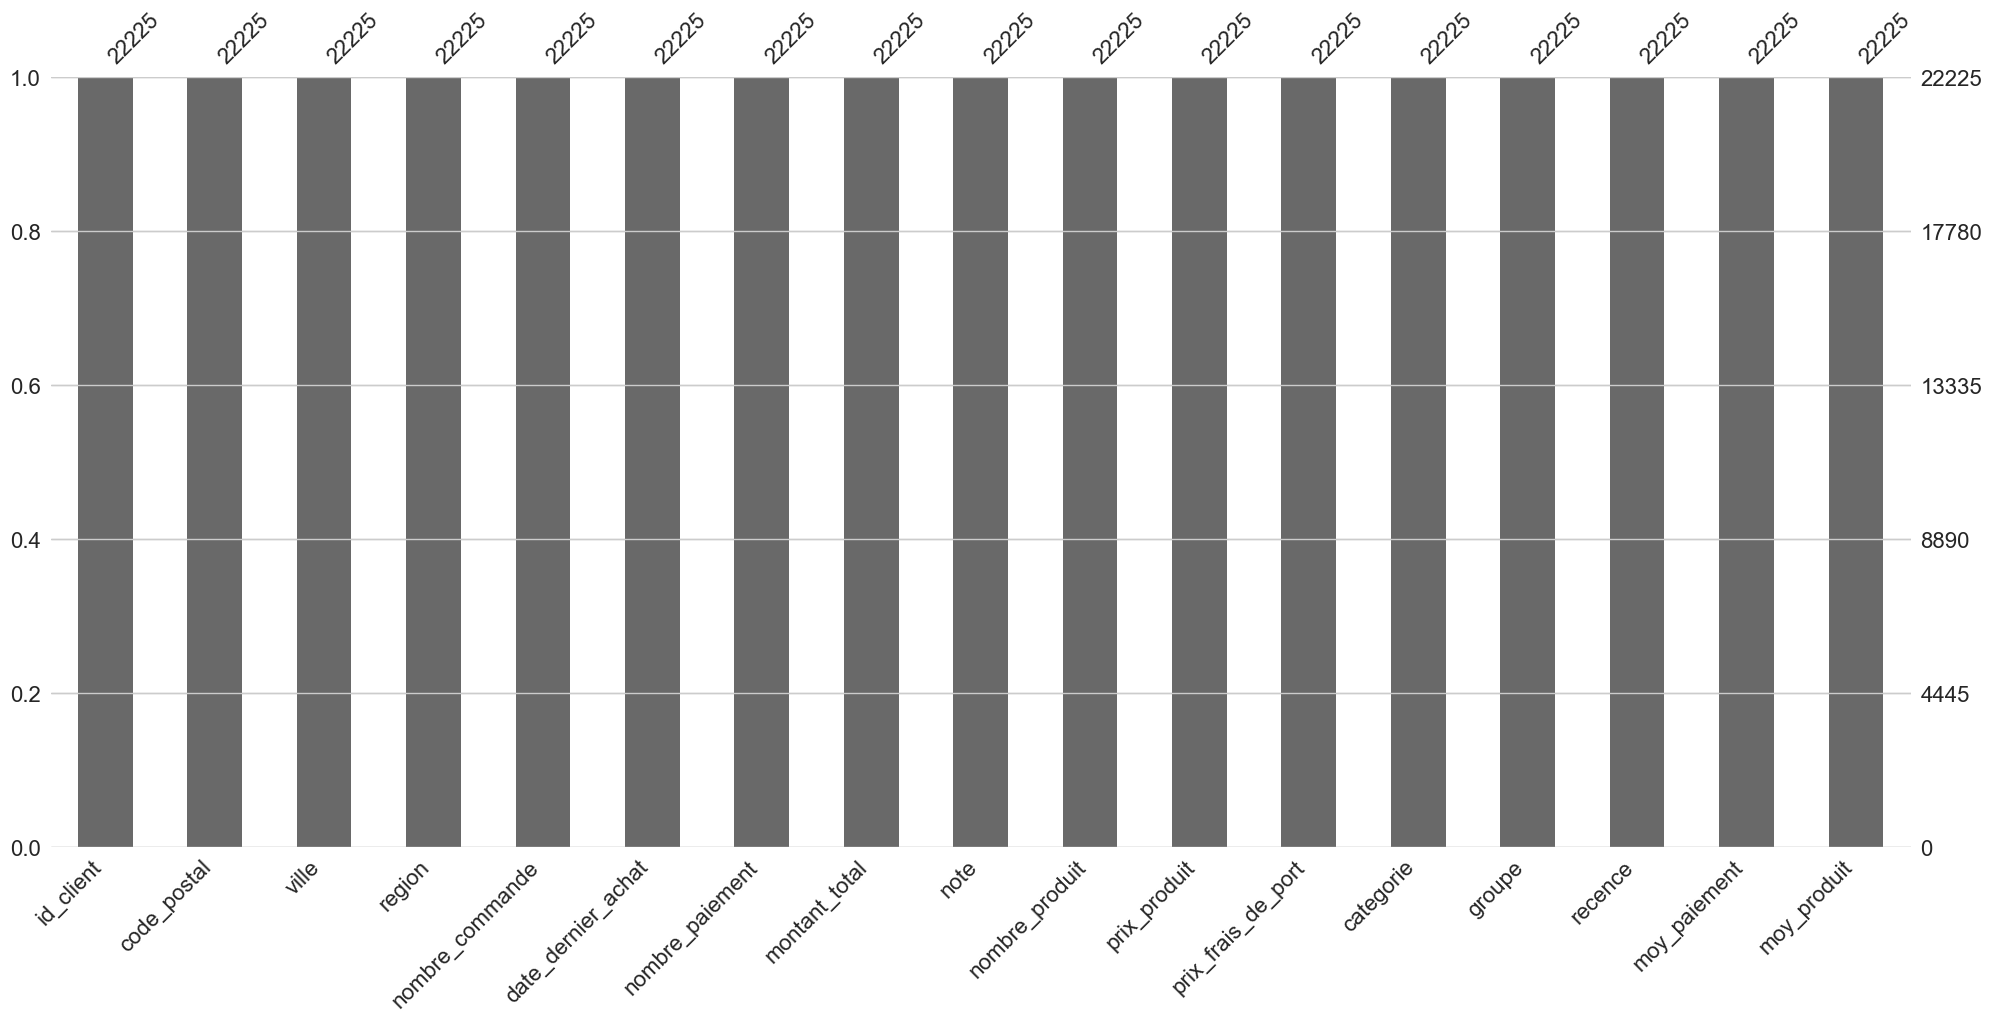

In [77]:
msno.bar(df_base)

In [13]:
for r, l in df_base.iterrows():
    z = maxi- df_base.loc[r, 'date_dernier_achat']
    day = z.days
    df_base.loc[r,'recence'] = day

In [58]:
df_base.loc[:,'moy_paiement'] = (df_base.loc[:,'nombre_paiement']/df_base.loc[:,'nombre_commande'])
df_base.loc[:,'moy_produit'] = (df_base.loc[:,'nombre_produit']/df_base.loc[:,'nombre_commande'])

In [14]:
df_base.sort_values(by=['date_dernier_achat'], ascending=True)

,id_client,code_postal,ville,region,nombre_commande,date_dernier_achat,nombre_paiement,montant_total,note,nombre_produit,prix_produit,prix_frais_de_port,categorie,groupe,recence
21864,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,1,2016-09-04 21:15:19,1,136.23,1,2,72.89,63.34,furniture_decor,decor_and_other,361.0
7717,32ea3bdedab835c3aa6cb68ce66565ef,4106,sao paulo,SP,1,2016-10-03 09:44:50,1,45.46,4,1,29.9,15.56,watches_gifts,mode,332.0
10864,2f64e403852e6893ae37485d5fcacdaf,98280,panambi,RS,1,2016-10-03 16:56:50,1,39.09,4,1,21.9,17.19,sports_leisure,other,332.0
1596,61db744d2f835035a5625b59350c6b63,90040,porto alegre,RS,1,2016-10-03 21:13:36,1,53.73,3,1,36.49,17.24,sports_leisure,other,332.0
11061,8d3a54507421dbd2ce0a1d58046826e0,13185,hortolandia,SP,1,2016-10-03 22:06:03,6,133.46,1,1,119.9,13.56,furniture_decor,decor_and_other,332.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15900,aaa8491c0e8d7e878389cce7f1afdb1d,6340,carapicuiba,SP,1,2017-08-31 22:39:02,3,209.97,5,1,195.0,14.97,bed_bath_table,home,0.0
15578,ed2b3f325265fe93991e55adab759757,26265,nova iguacu,RJ,1,2017-08-31 23:08:31,1,77.57,4,1,59.9,17.67,garden_tools,garden,0.0
15370,29309c6b1e5e1af920032cf226df47b4,22050,rio de janeiro,RJ,1,2017-08-31 23:15:39,8,101.93,1,1,84.9,17.03,health_beauty,beauty,0.0
8671,c64bcc08b5390ae3c789aff9c39b8597,8738,mogi das cruzes,SP,1,2017-08-31 23:17:32,2,139.62,1,1,129.9,9.72,consoles_games,pc_and_electronics,0.0


#### Conversion des colonnes

In [15]:
df_base['date_dernier_achat'] = df_base['date_dernier_achat'].astype('datetime64[ns]')
df_base[['nombre_paiement', 'montant_total', 'prix_produit', 'prix_frais_de_port']] = \
df_base[['nombre_paiement', 'montant_total', 'prix_produit', 'prix_frais_de_port']].astype('float')
df_base[['code_postal','nombre_commande','nombre_paiement','note', 'nombre_produit']]= \
df_base[['code_postal','nombre_commande','nombre_paiement','note', 'nombre_produit']].astype('int')
df_base['recence'] = df_base['recence'].astype('int')

In [16]:
df_base.dtypes

id_client                     object
code_postal                    int32
ville                         object
region                        object
nombre_commande                int32
date_dernier_achat    datetime64[ns]
nombre_paiement                int32
montant_total                float64
note                           int32
nombre_produit                 int32
prix_produit                 float64
prix_frais_de_port           float64
categorie                     object
groupe                        object
recence                        int32
dtype: object

In [59]:
#Effectif de base 23% de l'effectif total
(df_base.shape[0]/94989)*100

23.39744602006548

## Déterminer la fréquence de maintenance

- Ajout par semaine
- Observation de l'ARI
- Determiner un seuil 
- Determiner un fréquence de maintenance

In [83]:
days7 = datetime.timedelta(days = 7)
base_maxi = maxi
var_maxi = maxi + days7 

df_evol = df_base.copy()

X = df_base[['recence', 'montant_total','note','nombre_commande', 'moy_paiement','moy_produit', 'groupe']]
    
#Partitions des transformations
quant = ['recence']
mont = ['montant_total']
qual = X.select_dtypes(include =['object']).columns
    
#Transformations et Encodage
scaler = preprocessing.StandardScaler()
log = preprocessing.FunctionTransformer(np.log1p)
encoder = preprocessing.OneHotEncoder(handle_unknown = 'ignore') 


#Transformation de colonnes
preprocessor = ColumnTransformer(transformers=[("quant", scaler, quant),
                                               ("qual", encoder, qual), 
                                               ('mont', log, mont)],
                                 remainder='passthrough')

#Modèle init
cls = cluster.KMeans(n_clusters=5)
pipeline_mod = Pipeline([("preprocessor", preprocessor), 
                                 ("model", cls)]).fit(X)
lab = pipeline_mod.named_steps['model'].labels_ #Labels des clusters

lab_init = lab

#### Variation du clustering sur 53 semaines

In [84]:
ari=[]


for n in range(53):
    
    X2 = df_evol[['recence', 'montant_total','note','nombre_commande', 'moy_paiement','moy_produit', 'groupe']]
    
    #Modèle évol
    cls_2 = cluster.KMeans(n_clusters=5)
    pipeline_mod = Pipeline([("preprocessor", preprocessor), 
                             ("model", cls_2)]).fit(X2)
    lab_2 = pipeline_mod.named_steps['model'].labels_ #Labels des clusters
    lab_comp = lab_2[0:df_base.shape[0]]
    a = metrics.adjusted_rand_score(lab_init, lab_comp)
    ari.append(a)
    
    
    
    df_var = df.loc[ (df['date_dernier_achat'] < var_maxi) & (df['date_dernier_achat'] >= base_maxi)]
    df_var = df_var.sort_values(by=['date_dernier_achat'], ascending=True)
    
    for r,l in df_var.iterrows():
        
        z = var_maxi - l['date_dernier_achat']
        day = z.days
        
        if l['id_client'] in df_evol['id_client'].tolist():
            
            ind = df_evol.loc[df_evol['id_client'] == l['id_client']].index[0]
            
            df_evol.at[ind, 'id_client'] = l['id_client']
            df_evol.at[ind, 'nombre_commande'] = (df_evol.loc[ind, 'nombre_commande'] + 1)
            df_evol.at[ind, 'nombre_paiement'] = (df_evol.loc[ind, 'nombre_paiement'] + l['nombre_paiement'])
            df_evol.at[ind, 'montant_total'] = (df_evol.loc[ind, 'montant_total'] + l['montant_total'])
            df_evol.at[ind, 'nombre_produit'] = (df_evol.loc[ind, 'nombre_produit'] + l['nombre_produit'])
            df_evol.at[ind, 'prix_produit'] = (df_evol.loc[ind, 'prix_produit'] + l['prix_produit'])
            df_evol.at[ind, 'prix_frais_de_port'] = (df_evol.loc[ind, 'prix_frais_de_port'] + l['prix_frais_de_port'])
            df_evol.at[ind, 'date_dernier_achat'] = l['date_dernier_achat']
            df_evol.at[ind, 'code_postal'] = l['code_postal']
            df_evol.at[ind, 'ville'] = l['ville']
            df_evol.at[ind, 'region'] = l['region']
            df_evol.at[ind, 'note'] = round(((df_evol.loc[ind, 'note'] + l['nombre_produit']) / 2), 0)
            df_evol.at[ind, 'categorie'] = l['categorie']
            df_evol.at[ind, 'groupe'] = l['groupe']
            df_evol.at[ind, 'recence'] = day
            df_evol.at[ind, 'moy_produit'] = (df_evol.loc[ind,'nombre_produit']/df_evol.loc[ind,'nombre_commande'])
            df_evol.at[ind, 'moy_paiement'] = (df_evol.loc[ind,'nombre_paiement']/df_evol.loc[ind,'nombre_commande'])
        else:
            ind=df_evol.shape[0]
            df_evol.loc[ind, 'id_client'] = l['id_client']
            df_evol.loc[ind, 'nombre_commande'] = 1
            df_evol.loc[ind, 'nombre_paiement'] = l['nombre_paiement']
            df_evol.loc[ind, 'montant_total'] = l['montant_total']
            df_evol.loc[ind, 'nombre_produit'] = l['nombre_produit']
            df_evol.loc[ind, 'prix_produit'] = l['prix_produit']
            df_evol.loc[ind, 'prix_frais_de_port'] = l['prix_frais_de_port']
            df_evol.loc[ind, 'date_dernier_achat'] = l['date_dernier_achat']
            df_evol.loc[ind, 'code_postal'] = l['code_postal']
            df_evol.loc[ind, 'ville'] = l['ville']
            df_evol.loc[ind, 'region'] = l['region']
            df_evol.loc[ind, 'note'] = l['note']
            df_evol.loc[ind, 'categorie'] = l['categorie']
            df_evol.loc[ind, 'groupe'] = l['groupe']
            df_evol.loc[ind, 'recence'] = day
            df_evol.loc[ind, 'moy_produit'] = l['nombre_produit']
            df_evol.loc[ind, 'moy_paiement'] = l['nombre_paiement']
            
    base_maxi = var_maxi
    var_maxi = var_maxi + days7
    
    
len(ari)

53

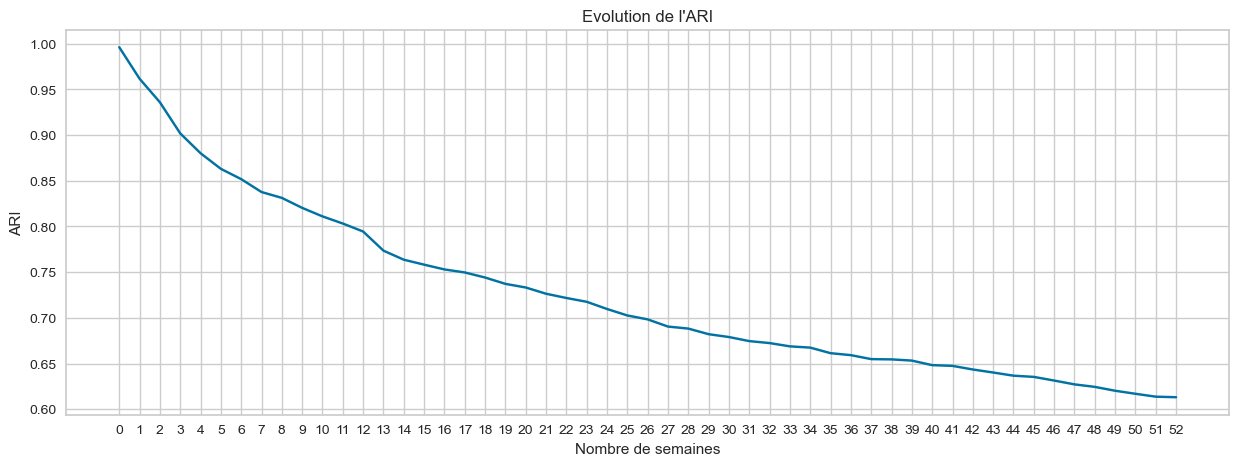

In [85]:
# Visualisation de l'évolution de l'ARI
plt.figure(figsize=(15,5))
plt.plot(range(53), ari)
plt.xticks(range(53))
plt.xlabel("Nombre de semaines")
plt.ylabel("ARI")
plt.title("Evolution de l'ARI")
plt.savefig("./Visualisations/ARI_temporelle", bbox_inches='tight' )
plt.show()

#### Déterminer la fréquence de mise a jour 

In [86]:
days7 = datetime.timedelta(days = 7)
base_maxi = maxi
var_maxi = maxi + days7 

df_evol_2= df_base.copy()

ari_2 = []
maj = []


for n in range(53):
    
    X2 = df_evol_2[['recence', 'montant_total','note','nombre_commande', 'moy_paiement','moy_produit', 'groupe']]
    
    #Modèle évol 
    cls_2 = cluster.KMeans(n_clusters=5)
    pipeline_mod = Pipeline([("preprocessor", preprocessor), 
                             ("model", cls_2)]).fit(X2)
    lab_2 = pipeline_mod.named_steps['model'].labels_ #Labels des clusters
    lab_comp = lab_2[0:df_base.shape[0]]
    a = metrics.adjusted_rand_score(lab_init, lab_comp)
    ari_2.append(a)
    
    if a <0.85:
        lab_init = lab_2[0:df_base.shape[0]]
        maj.append(n)
    
    
    
    df_var = df.loc[ (df['date_dernier_achat'] < var_maxi) & (df['date_dernier_achat'] >= base_maxi)]
    df_var = df_var.sort_values(by=['date_dernier_achat'], ascending=True)
    
    for r,l in df_var.iterrows():
        
        z = var_maxi - l['date_dernier_achat']
        day = z.days
        
        if l['id_client'] in df_evol_2['id_client'].tolist():
            
            ind = df_evol_2.loc[df_evol_2['id_client'] == l['id_client']].index[0]
            
            df_evol_2.at[ind, 'id_client'] = l['id_client']
            df_evol_2.at[ind, 'nombre_commande'] = (df_evol_2.loc[ind, 'nombre_commande'] + 1)
            df_evol_2.at[ind, 'nombre_paiement'] = (df_evol_2.loc[ind, 'nombre_paiement'] + l['nombre_paiement'])
            df_evol_2.at[ind, 'montant_total'] = (df_evol_2.loc[ind, 'montant_total'] + l['montant_total'])
            df_evol_2.at[ind, 'nombre_produit'] = (df_evol_2.loc[ind, 'nombre_produit'] + l['nombre_produit'])
            df_evol_2.at[ind, 'prix_produit'] = (df_evol_2.loc[ind, 'prix_produit'] + l['prix_produit'])
            df_evol_2.at[ind, 'prix_frais_de_port'] = (df_evol_2.loc[ind, 'prix_frais_de_port'] + l['prix_frais_de_port'])
            df_evol_2.at[ind, 'date_dernier_achat'] = l['date_dernier_achat']
            df_evol_2.at[ind, 'code_postal'] = l['code_postal']
            df_evol_2.at[ind, 'ville'] = l['ville']
            df_evol_2.at[ind, 'region'] = l['region']
            df_evol_2.at[ind, 'note'] = round(((df_evol_2.loc[ind, 'note'] + l['nombre_produit']) / 2), 0)
            df_evol_2.at[ind, 'categorie'] = l['categorie']
            df_evol_2.at[ind, 'groupe'] = l['groupe']
            df_evol_2.at[ind, 'recence'] = day
            df_evol_2.at[ind, 'moy_produit'] = (df_evol_2.loc[ind,'nombre_produit']/df_evol_2.loc[ind,'nombre_commande'])
            df_evol_2.at[ind, 'moy_paiement'] = (df_evol_2.loc[ind,'nombre_paiement']/df_evol_2.loc[ind,'nombre_commande'])
            
        else:
            ind=df_evol_2.shape[0]
            df_evol_2.loc[ind, 'id_client'] = l['id_client']
            df_evol_2.loc[ind, 'nombre_commande'] = 1
            df_evol_2.loc[ind, 'nombre_paiement'] = l['nombre_paiement']
            df_evol_2.loc[ind, 'montant_total'] = l['montant_total']
            df_evol_2.loc[ind, 'nombre_produit'] = l['nombre_produit']
            df_evol_2.loc[ind, 'prix_produit'] = l['prix_produit']
            df_evol_2.loc[ind, 'prix_frais_de_port'] = l['prix_frais_de_port']
            df_evol_2.loc[ind, 'date_dernier_achat'] = l['date_dernier_achat']
            df_evol_2.loc[ind, 'code_postal'] = l['code_postal']
            df_evol_2.loc[ind, 'ville'] = l['ville']
            df_evol_2.loc[ind, 'region'] = l['region']
            df_evol_2.loc[ind, 'note'] = l['note']
            df_evol_2.loc[ind, 'categorie'] = l['categorie']
            df_evol_2.loc[ind, 'groupe'] = l['groupe']
            df_evol_2.loc[ind, 'recence'] = day
            df_evol_2.loc[ind, 'moy_produit'] = l['nombre_produit']
            df_evol_2.loc[ind, 'moy_paiement'] = l['nombre_paiement']
            
    base_maxi = var_maxi
    var_maxi = var_maxi + days7
    
    
len(ari_2)

53

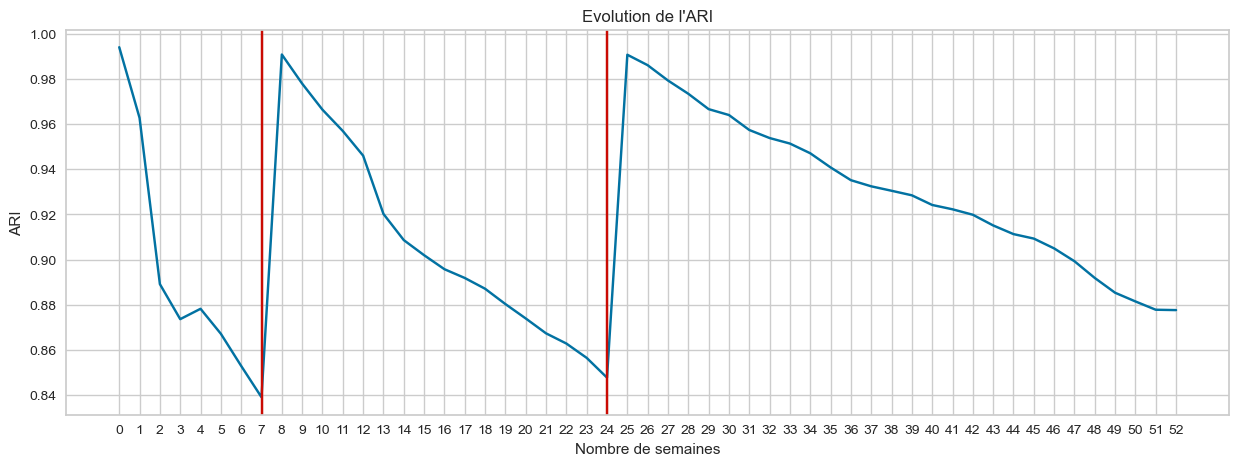

In [87]:
# Visualisation de l'évolution de l'ARI
plt.figure(figsize=(15,5))
plt.plot(range(53), ari_2)
plt.xticks(range(53))
for n in maj:
    plt.axvline(x=n, c='r')
plt.xlabel("Nombre de semaines")
plt.ylabel("ARI")
plt.title("Evolution de l'ARI")
plt.savefig("./Visualisations/ARI_temporelle_avec_maintenance", bbox_inches='tight' )
plt.show()

#### Mise en place d'une maintenance toutes les 3 semaines

In [102]:
days7 = datetime.timedelta(days = 7)
base_maxi = maxi
var_maxi = maxi + days7 

df_evol_3= df_base.copy()

ari_3 = []
maj_2 = []

lab_init_2 = lab


for n in range(53):
    
    X2 = df_evol_3[['recence', 'montant_total','note','nombre_commande', 'moy_paiement','moy_produit', 'groupe']]
    
    
    #Modèle évol 
    cls_3 = cluster.KMeans(n_clusters=5)
    pipeline_mod = Pipeline([("preprocessor", preprocessor), 
                             ("model", cls_3)]).fit(X2)
    lab_3 = pipeline_mod.named_steps['model'].labels_ #Labels des clusters
    lab_comp = lab_3[0:len(lab_init_2)]
    a = metrics.adjusted_rand_score(lab_init_2, lab_comp)
    ari_3.append(a)
    
    if n in range(0,53,3): #si n est pair (pour fixer un ecart de 2 semaines)
        lab_init_2 = lab_comp
    
    if a <0.80:
        maj_2.append(n)
    
    
    
    df_var = df.loc[ (df['date_dernier_achat'] < var_maxi) & (df['date_dernier_achat'] >= base_maxi)]
    df_var = df_var.sort_values(by=['date_dernier_achat'], ascending=True)
    
    for r,l in df_var.iterrows():
        
        z = var_maxi - l['date_dernier_achat']
        day = z.days
        
        if l['id_client'] in df_evol_3['id_client'].tolist():
            
            ind = df_evol_3.loc[df_evol_3['id_client'] == l['id_client']].index[0]
            
            df_evol_3.at[ind, 'id_client'] = l['id_client']
            df_evol_3.at[ind, 'nombre_commande'] = (df_evol_3.loc[ind, 'nombre_commande'] + 1)
            df_evol_3.at[ind, 'nombre_paiement'] = (df_evol_3.loc[ind, 'nombre_paiement'] + l['nombre_paiement'])
            df_evol_3.at[ind, 'montant_total'] = (df_evol_3.loc[ind, 'montant_total'] + l['montant_total'])
            df_evol_3.at[ind, 'nombre_produit'] = (df_evol_3.loc[ind, 'nombre_produit'] + l['nombre_produit'])
            df_evol_3.at[ind, 'prix_produit'] = (df_evol_3.loc[ind, 'prix_produit'] + l['prix_produit'])
            df_evol_3.at[ind, 'prix_frais_de_port'] = (df_evol_3.loc[ind, 'prix_frais_de_port'] + l['prix_frais_de_port'])
            df_evol_3.at[ind, 'date_dernier_achat'] = l['date_dernier_achat']
            df_evol_3.at[ind, 'code_postal'] = l['code_postal']
            df_evol_3.at[ind, 'ville'] = l['ville']
            df_evol_3.at[ind, 'region'] = l['region']
            df_evol_3.at[ind, 'note'] = round(((df_evol_3.loc[ind, 'note'] + l['nombre_produit']) / 2), 0)
            df_evol_3.at[ind, 'categorie'] = l['categorie']
            df_evol_3.at[ind, 'groupe'] = l['groupe']
            df_evol_3.at[ind, 'recence'] = day
            df_evol_3.at[ind, 'moy_produit'] = (df_evol_3.at[ind,'nombre_produit']/df_evol_3.at[ind,'nombre_commande'])
            df_evol_3.at[ind, 'moy_paiement'] = (df_evol_3.at[ind,'nombre_paiement']/df_evol_3.at[ind,'nombre_commande'])
            
        else:
            ind=df_evol_3.shape[0]
            df_evol_3.loc[ind, 'id_client'] = l['id_client']
            df_evol_3.loc[ind, 'nombre_commande'] = 1
            df_evol_3.loc[ind, 'nombre_paiement'] = l['nombre_paiement']
            df_evol_3.loc[ind, 'montant_total'] = l['montant_total']
            df_evol_3.loc[ind, 'nombre_produit'] = l['nombre_produit']
            df_evol_3.loc[ind, 'prix_produit'] = l['prix_produit']
            df_evol_3.loc[ind, 'prix_frais_de_port'] = l['prix_frais_de_port']
            df_evol_3.loc[ind, 'date_dernier_achat'] = l['date_dernier_achat']
            df_evol_3.loc[ind, 'code_postal'] = l['code_postal']
            df_evol_3.loc[ind, 'ville'] = l['ville']
            df_evol_3.loc[ind, 'region'] = l['region']
            df_evol_3.loc[ind, 'note'] = l['note']
            df_evol_3.loc[ind, 'categorie'] = l['categorie']
            df_evol_3.loc[ind, 'groupe'] = l['groupe']
            df_evol_3.loc[ind, 'recence'] = day
            df_evol_3.at[ind, 'moy_produit'] = l['nombre_produit']
            df_evol_3.at[ind, 'moy_paiement'] = l['nombre_paiement']
            
    base_maxi = var_maxi
    var_maxi = var_maxi + days7
    
    
len(ari_3)

53

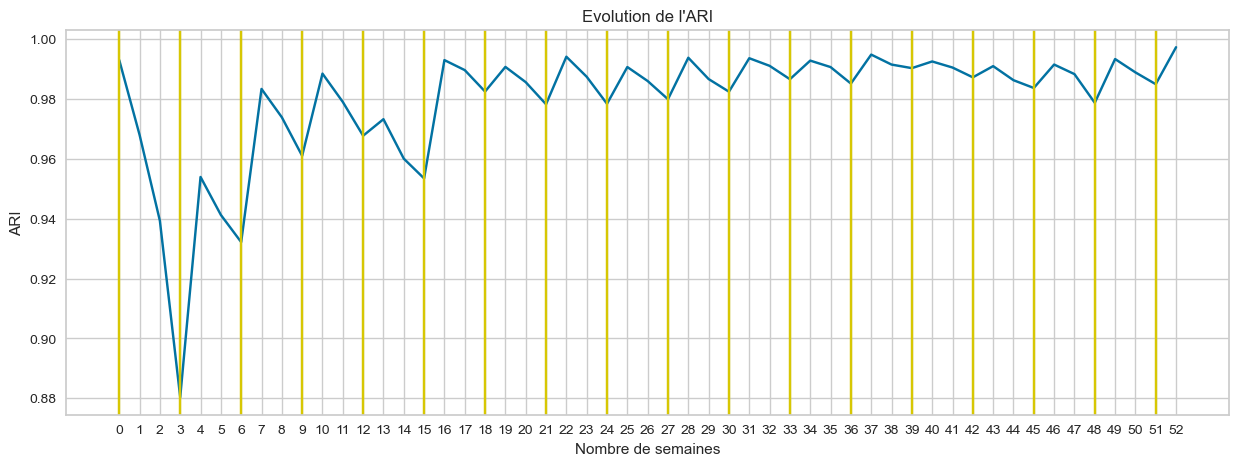

In [103]:
# Visualisation de l'évolution de l'ARI
plt.figure(figsize=(15,5))
plt.plot(range(53), ari_3)
plt.xticks(range(53))
for n in maj_2:
    plt.axvline(x=n, c='r')
for n in range(0, 53 , 3):
    plt.axvline(x=n, c='y')
plt.xlabel("Nombre de semaines")
plt.ylabel("ARI")
plt.title("Evolution de l'ARI")
plt.savefig("./Visualisations/ARI_temporelle_avec_maintenance_2_semaines", bbox_inches='tight' )
plt.show()